In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from scipy.interpolate import interp1d

In [39]:
# CONSTANTS & PARAMETERS
Na = 19                
Nc = 11               
G0 = 1.7              
lab_IP = 8.6          
fy = 10              
J_Er = 1.5 * 10**(-7)
T_ISM = 80
ne = 7.5 * 10**(-3)

# PAH FUNCTIONS
def approx_surface_area_pah(Nc): 
    s_area = 5 * 10**(-16) * Nc
    return s_area

def approx_radius_pah(Nc):
    a = 0.9 * 10**(-8) * np.sqrt(Nc)
    return a

def FUV_absorption_cross_section(Nc):
    sigma = 7 * 10**(-18) * Nc
    return sigma

def UV_absorption_timescale(Nc,G0):
    t_UV = 1.4 * 10**(9) / (Nc*G0)
    return t_UV

def vibrational_degrees_of_freedom(Na):
    return 3*Na - 6

def ionization_potential(Z, Nc):
    IP = 4.4 + (Z + 0.5) * 25.1/np.sqrt(Nc)
    return IP

def photo_el_ionization_rate(Nc, G0, fy):
    J_pe = 2.5 * 10**(-13) * (13.6-lab_IP)**2 * Nc * G0 * fy
    return J_pe

def neutral_fraction(Nc, G0, T_ISM, J_Er, J_Pe, ne):
    # y0 = (J_Pe / J_Er) * np.sqrt(Nc) * G0 * np.sqrt(T_ISM) / ne
    # y1 = 3.5 * 10**(-6) * np.sqrt(Nc) * G0 * np.sqrt(T_ISM) / ne
    # y2 = 1.3 * 10**(-4) * np.sqrt(Nc) * G0 * np.sqrt(T_ISM) / ne
    y4 = (J_Pe / J_Er * ne) 
    #factor = (J_Pe / J_Er) 
    f0 = 1/(1 + y4)
    return f0

def neutralization_rate(Nc, G0, T_ISM, J_Er, J_Pe, ne):
    k_n = 2.9e-7 * phi_pah * np.sqrt()
# CALCULATIONS
print("Vibrational degrees of freedom:", vibrational_degrees_of_freedom(Na))
print("Surface area:", approx_surface_area_pah(Nc), "cm^2")
print("Radius:", approx_radius_pah(Nc), "cm")
print("FUV cross section:", FUV_absorption_cross_section(Nc), "cm^2")
print("UV absorption timescale:", UV_absorption_timescale(Nc, G0), "seconds", "which is equivalent to ", UV_absorption_timescale(Nc, G0) / 3.154e7, "years")
print("Ionization potential (Z=0):", ionization_potential(0, Nc), "eV", "and the laboratory value for 1-cyanonaphthalene has been measured to be 8.59 - 8.61 eV")
print("Ionization potential (Z=1):", ionization_potential(1, Nc), "eV")
print("Photoelectron ionization rate:", photo_el_ionization_rate(Nc, G0, fy), "electrons s^-1")
print("Neutral fraction:", neutral_fraction(Nc, G0, T_ISM, J_Er, photo_el_ionization_rate(Nc, G0, fy), ne), "which is the ratio of neutral to ionized PAHs")

Vibrational degrees of freedom: 51
Surface area: 5.5e-15 cm^2
Radius: 2.98496231131986e-08 cm
FUV cross section: 7.7e-17 cm^2
UV absorption timescale: 74866310.16042781 seconds which is equivalent to  2.3736940444016428 years
Ionization potential (Z=0): 8.183967374450933 eV and the laboratory value for 1-cyanonaphthalene has been measured to be 8.59 - 8.61 eV
Ionization potential (Z=1): 15.751902123352803 eV
Photoelectron ionization rate: 1.1687500000000001e-09 electrons s^-1
Neutral fraction: 0.9999415659147419 which is the ratio of neutral to ionized PAHs


### Calculating the vibrational & rotational partition functions

In the case of cyanonapthalene, the most likely bond to break in the molecule would be the -CN bond as given by the reaction here:
C10H7CN+ → C10H6+ + HCN + ϵ (where ϵ is the kinetic energy)

In [40]:
# WAVENUMBER DATA
N1cyano_wavenumbers_list = pd.read_csv(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\strong_frequencies_neutral1cyano.csv', header=None).squeeze().tolist()
C1cyano_wavenumbers_list = pd.read_csv(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\strong_frequencies_cation1cyano.csv', header=None).squeeze().tolist()
TS_N1cyano_wavenumbers_list = pd.read_csv(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\transition_strong_frequencies_neutral1cyano.csv', header=None).squeeze().tolist()
TS_C1cyano_wavenumbers_list = pd.read_csv(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\transition_strong_frequencies_cation1cyano.csv', header=None).squeeze().tolist()

# PRINCIPAL MOMENTS OF INERTIA DATA & CONVERSION FACTORS
inertia_factor_amuAng = 1.6605390666000002e-47 # Principal moment of inertia from amu*angstrom^2 to kg*m^2
inertia_factor_au = 1.992851882e-46 # Principal moments of inertia from atomic units to kg*m^2

N1cyano_principal_moments = [341.37767327 * inertia_factor_amuAng, 532.72832397 * inertia_factor_amuAng, 874.10599724 * inertia_factor_amuAng] # Principal moments of inertia in kg*m^2
C1cyano_principal_moments = [341.39046846 * inertia_factor_amuAng, 535.88368599 * inertia_factor_amuAng, 877.27415445 * inertia_factor_amuAng]
TS_N1cyano_principal_moments = [1219.483541 * inertia_factor_au, 960.954403 * inertia_factor_au,  180.43794 * inertia_factor_au] 
TS_C1cyano_principal_moments = [1322.144212 * inertia_factor_au, 337.032003 * inertia_factor_au, 659.17620 * inertia_factor_au]

# CONSTANTS & PARAMETERS
c_cm = 2.99792458e10  # Speed of light in cm/s, since cm_freq is given in cm^-1
h = 6.62607015e-34 # Planck's constant in J/Hz
k_B = 1.380649e-23 # Boltzmann's constant in J/K
symmetry_number = 1 # 1-cyanonaphthalene is structurally asymmetric (also seen in principal moment inertias), so the symmetry number is 1. Also given in sigma notation
T_eval = 1000 # Temperature in K, evaluation of the partition function at 1000 K is done to see how many vibrational states are accessible at this temperature.

# FUNCTIONS
def scale_frequencies(wavenumber_list, scale_factor=0.96):
    return [freq * scale_factor for freq in wavenumber_list]

def vibrational_partition_function(wavenumbers_list, T):
    cm_freqs = np.array(wavenumbers_list)
    hz_freqs = cm_freqs * c_cm
    char_vib_temps = h * hz_freqs / k_B
    q_vibs = 1 / (1 - np.exp(-char_vib_temps / T))
    return np.prod(q_vibs)

def rotational_partition_function(symmetry_number, principal_moments, T):
    return (np.pi**2 / symmetry_number) * \
           np.sqrt(8*np.pi*principal_moments[0] * k_B*T / h**2) * \
           np.sqrt(8*np.pi*principal_moments[1] * k_B*T / h**2) * \
           np.sqrt(8*np.pi*principal_moments[2] * k_B*T / h**2)

def compute_partition_functions(wavenumbers_list, principal_moments, T, symmetry_number=1):
    q_vib = vibrational_partition_function(wavenumbers_list, T)
    q_rot = rotational_partition_function(symmetry_number, principal_moments, T)
    return q_vib, q_rot

# CALCULATIONS
scaled_TS_N_freqs = scale_frequencies(TS_N1cyano_wavenumbers_list, 0.96)
scaled_TS_C_freqs = scale_frequencies(TS_C1cyano_wavenumbers_list, 0.96)

q_vib_N, q_rot_N = compute_partition_functions(N1cyano_wavenumbers_list, N1cyano_principal_moments, T_eval)
q_vib_C, q_rot_C = compute_partition_functions(C1cyano_wavenumbers_list, C1cyano_principal_moments, T_eval)
q_vib_TS_N, q_rot_TS_N = compute_partition_functions(scaled_TS_N_freqs, TS_N1cyano_principal_moments, T_eval)
q_vib_TS_C, q_rot_TS_C = compute_partition_functions(scaled_TS_C_freqs, TS_C1cyano_principal_moments, T_eval)

print("Vibrational partition function (neutral 1-cyanonaphthalene):", q_vib_N, "The rotational partition function (neutral 1-cyanonaphthalene):", q_rot_N)
print("Vibrational partition function (cation 1-cyanonaphthalene):", q_vib_C, "The rotational partition function (cation 1-cyanonaphthalene):", q_rot_C)
print("Vibrational partition function (transition state neutral 1-cyanonaphthalene):", q_vib_TS_N, "The rotational partition function (transition state neutral 1-cyanonaphthalene):", q_rot_TS_N)
print("Vibrational partition function (transition state cation 1-cyanonaphthalene):", q_vib_TS_C, "The rotational partition function (transition state cation 1-cyanonaphthalene):", q_rot_TS_C)

Vibrational partition function (neutral 1-cyanonaphthalene): 5.544077488182599 The rotational partition function (neutral 1-cyanonaphthalene): 5916195.513425924
Vibrational partition function (cation 1-cyanonaphthalene): 25.157890192110596 The rotational partition function (cation 1-cyanonaphthalene): 5944545.396059827
Vibrational partition function (transition state neutral 1-cyanonaphthalene): 61684.14685472909 The rotational partition function (transition state neutral 1-cyanonaphthalene): 283682270.69831663
Vibrational partition function (transition state cation 1-cyanonaphthalene): 341272.7354960699 The rotational partition function (transition state cation 1-cyanonaphthalene): 334352555.04264796


The entropy change is: 110.59798643413164 cal/mol K
The entropy change is: 99.77995440629475 cal/mol K


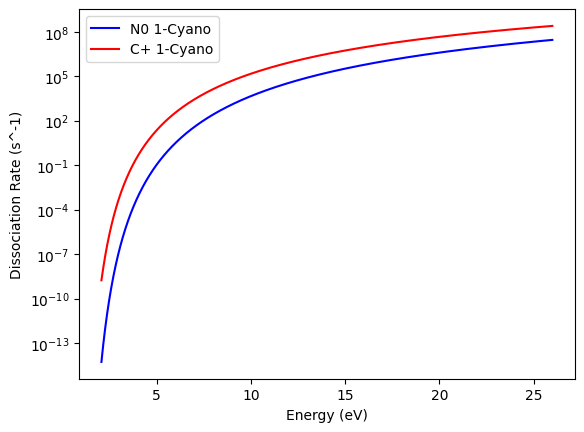

In [41]:
# CONSTANTS & PARAMETERS
h_eV = 4.135667696e-15 # Planck's constant in eV/Hz
k_B = 1.380649e-23 # Boltzmann's constant in J/K
R_gas = 8.31446261815324 # Ideal gas constant in J/(mol*K)
Na = 6.02214076e23 # Avogadro's number in mol^-1
T_eval = 1000 # Temperature in K, evaluation of the partition function at 1000 K is done to see how many vibrational states are accessible at this temperature.
max_photon_frequency = 6286772e9
min_photon_frequency = 5.0e14 
C_bond_energy = 3.16 # The dissocation/activation energy of the HCN bond of cation 1-cyanonaphthalene in eV, given in the paper by H. Stockett et al. (2023) DOI: 10.1038/s41557-023-01283-0.
N_bond_energy = 3.66 # Estimate of the activation energy for neutral 1-cyanonaphthalene, recommended by supervisor

# LISTS
k_diss_N_list = [] 
k_diss_C_list = [] 
NC_energies_list = [] 
frequency_list = np.logspace(np.log10(min_photon_frequency),np.log10(max_photon_frequency),num=10000) # Arrays of frequencies in Hz,adjust num for resolution

# FUNCTIONS
def d_entropy(q_vib_parent, q_rot_parent, q_vib_transition, q_rot_transition, activation_energy, T):
    delta_S = k_B * np.log((q_vib_transition * q_rot_transition) / (q_vib_parent * q_rot_parent)) + ((activation_energy * 1.602e-19) / T) 
    return delta_S

def PAH_effective_temperature(light_freq, Nc, bond_energy):
    T_eff = 2000 * ((h_eV * light_freq) / Nc) ** 0.4 * (1 - 0.2 * bond_energy / (h_eV * light_freq)) # energies in eV
    return T_eff

def pre_exponential_factor(T_eff, delta_S):
    k0 = k_B * T_eff / h * np.exp(1 + delta_S / R_gas)
    return k0

def unimolecular_dissociation_rate(k0, T_eff, bond_energy):
    k_diss = k0 * np.exp(-bond_energy * 1.602e-19 / (k_B * T_eff)) # energies in eV
    return k_diss

# CALCULATIONS
delta_S_N = d_entropy(q_vib_N, q_rot_N, q_vib_TS_N, q_rot_TS_N, N_bond_energy, T_eval)
delta_S_C = d_entropy(q_vib_C, q_rot_C, q_vib_TS_C, q_rot_TS_C, C_bond_energy, T_eval)
print("The entropy change is:", (delta_S_N * Na / 4.184), "cal/mol K") # Convert to cal/mol K
print("The entropy change is:", (delta_S_C * Na / 4.184), "cal/mol K") # Convert to cal/mol K

for i in frequency_list:
    N_T_eff = PAH_effective_temperature(i, Nc, N_bond_energy)
    C_T_eff = PAH_effective_temperature(i, Nc, C_bond_energy) 
    NC_energies_list.append(h_eV * i) 
    
    k0_N = pre_exponential_factor(N_T_eff, delta_S_N)
    k_diss_N = unimolecular_dissociation_rate(k0_N, N_T_eff, N_bond_energy)
    k_diss_N_list.append(k_diss_N) 

    k0_C = pre_exponential_factor(C_T_eff, delta_S_C)
    k_diss_C = unimolecular_dissociation_rate(k0_C, C_T_eff, C_bond_energy)
    k_diss_C_list.append(k_diss_C) 

# OPTIONAL PLOTTING
plt.plot(NC_energies_list, k_diss_N_list, label='N0 1-Cyano', color='blue')
plt.plot(NC_energies_list, k_diss_C_list, label='C+ 1-Cyano', color='red')
plt.legend()
plt.xlabel('Energy (eV)')
plt.ylabel('Dissociation Rate (s^-1)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\Teff_rates.png')

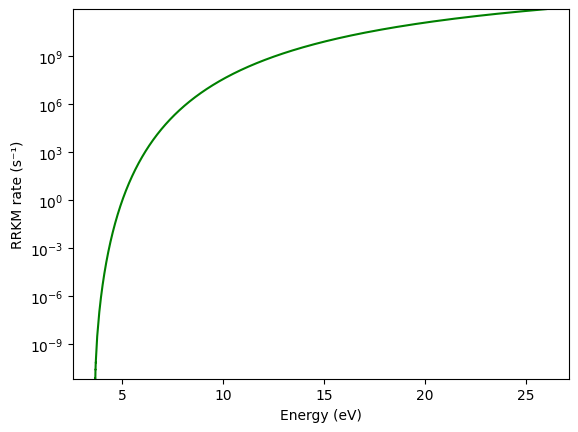

In [42]:
# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\densumout_26eV.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\TS-1-cyanonaphthalene\vibs\TSdensumout_26eV.out',
    skiprows=114,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56 # Planck's constant in eV/cm^-1
E0_cm = 29520                            # Activation energy in cm^-1 (rounded to cm_grain)
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
N_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        # print("Energy below threshold:", energy)
        continue

    E_available = energy - E0_cm
    # print("E_available:", E_available)
    index = int(E_available / cm_grain)
    # print("Index:", index)

    TS_sum_val = TS_sum_of_states_list[index]
    #print("sum of states:", TS_sum_val, "and density of states:", density)
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    N_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

# Converts energies from cm^-1 to eV
N_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, color='green')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(N_k_RRKM_list), max(N_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\N_RRKM.png')


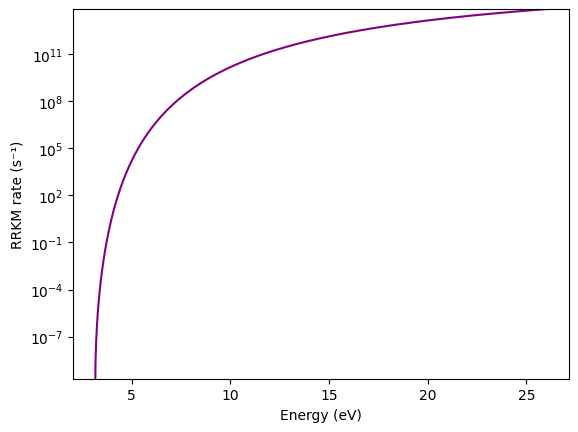

In [43]:
# DENSUM OUTPUT DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-1-cyanonaphthalene\vibs\densum.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\TS-C-1-cyanonaphthalene\vibs\densum.out',
    skiprows=114,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
h_wavenumber = 4.135667696e-15 * 8065.56
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4                
cm_grain = 10

# LISTS
density_of_states_list = df1["Density"].tolist()
TS_sum_of_states_list = df2["Sum"].tolist()
energies_list = df1["E-Emin"].tolist()
C_k_RRKM_list = []
filtered_energies_list = []

# FUNCTIONS
def RRKM_dissociation_rate(reaction_degen, TS_sum_of_states, density_of_states):
    return (reaction_degen * TS_sum_of_states) / (h_wavenumber * density_of_states)

# CALCULATIONS
for energy, density in zip(energies_list, density_of_states_list):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    TS_sum_val = TS_sum_of_states_list[index]
    k = RRKM_dissociation_rate(reaction_degen=1, TS_sum_of_states=TS_sum_val, density_of_states=density)
    C_k_RRKM_list.append(k)
    filtered_energies_list.append(energy)

C_RRKM_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='purple')
plt.xlabel('Energy (eV)')
plt.ylabel('RRKM rate (s⁻¹)')
plt.yscale('log')
plt.ylim(min(C_k_RRKM_list), max(C_k_RRKM_list))
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\C_RRKM.png')

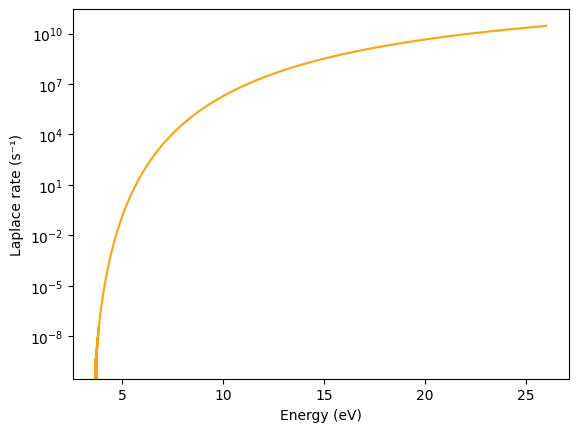

In [44]:
# INVERSE LAPLACE DISSOCIATON RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\1-cyanonaphthalene\vibs\densum.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
T_eff = 1000
h = 6.62607015e-34 
k_B = 1.380649e-23 
E0_cm = 29520                           
cm_to_eV = 1.239841984e-4
cm_grain = 10

# LISTS
N_k_Laplace_list = []
filtered_energies_list = []
energies_list = df["E-Emin"]
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_1000K(T_eff):
    A_diss_1000K = k_B * T_eff / h
    return A_diss_1000K

def Laplace_dissociation_rate(A_diss_1000K, DOS_E_Ea, DOS_E):
    k_diss_laplace = (A_diss_1000K * DOS_E_Ea) / DOS_E
    return k_diss_laplace
    
# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = Laplace_dissociation_rate(A_diss_1000K=(pre_exponential_factor_1000K(T_eff)), DOS_E_Ea=changed_DOS, DOS_E=unchanged_DOS)
    N_k_Laplace_list.append(k)
    filtered_energies_list.append(energy)

N_LP_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(N_LP_filtered_energies_list_eV, N_k_Laplace_list, color='orange')
plt.xlabel('Energy (eV)')
plt.ylabel('Laplace rate (s⁻¹)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\N_LP.png')


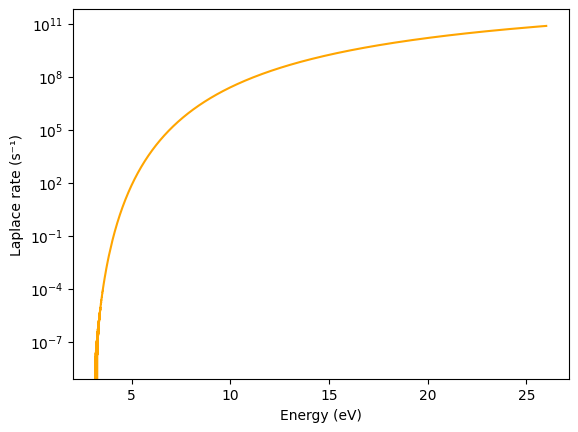

In [45]:
# INVERSE LAPLACE DISSOCIATON RATE

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-1-cyanonaphthalene\vibs\densum.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
T_eff = 1000
h = 6.62607015e-34 
k_B = 1.380649e-23 
E0_cm = 25490                           
cm_to_eV = 1.239841984e-4
cm_grain = 10

# LISTS
C_k_Laplace_list = []
filtered_energies_list = []
energies_list = df["E-Emin"]
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_1000K(T_eff):
    A_diss_1000K = k_B * T_eff / h
    return A_diss_1000K

def Laplace_dissociation_rate(A_diss_1000K, DOS_E_Ea, DOS_E):
    k_diss_laplace = (A_diss_1000K * DOS_E_Ea) / DOS_E
    return k_diss_laplace
    
# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= E0_cm:
        continue

    E_available = energy - E0_cm
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = Laplace_dissociation_rate(A_diss_1000K=(pre_exponential_factor_1000K(T_eff)), DOS_E_Ea=changed_DOS, DOS_E=unchanged_DOS)
    C_k_Laplace_list.append(k)
    filtered_energies_list.append(energy)

LP_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(LP_filtered_energies_list_eV, C_k_Laplace_list, color='orange')
plt.xlabel('Energy (eV)')
plt.ylabel('Laplace rate (s⁻¹)')
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\C_LP.png')


Pre-exponential factor for RF: 577413.0178419732 s^-1


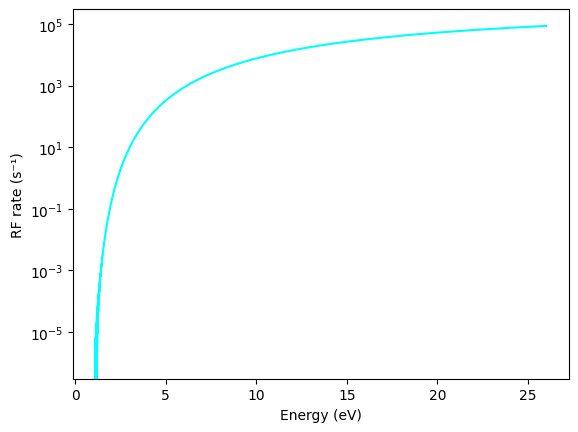

<Figure size 640x480 with 0 Axes>

In [46]:
# Recurrent fluoresence rate

# DOS DATA
df = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-1-cyanonaphthalene\vibs\densum.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

# CONSTANTS & PARAMETERS
eps_0 = 8.854e-12   # Vacuum permitivity in F/m
m_e = 9.109e-31     # Electron mass in kg
e = 1.602e-19       # Elementary charge in C
c = 2.998e8         # Speed of light in m/s
f_osc = 0.011       # Oscillator strength for RF from H. Stocket et al. https://doi.org/10.1038/s41467-023-36092-0. Modeled using Franck-Condon-Herzberg-Teller simulation at the ωB97X-D/cc-pVDZ level of theory.
v_el = 1.10 / h_eV  # Electronic energy in Hz for cation 1-cyanonaphthalene derived from H. Stocket et al. https://doi.org/10.1038/s41467-023-36092-0. 
wave_v_el = 8870    # cm^-1 for cation 1-cyanonaphthalene

# LISTS
k_RF_list = []
filtered_energies_list = []
energies_list = df["E-Emin"].tolist()
density_of_states_list1 = df["Density"].tolist()
density_of_states_list2 = df["Density"].tolist()

# FUNCTIONS
def pre_exponential_factor_RF(v_el, f_osc):
    A_RF = (2 * np.pi * (v_el ** 2) * (e **2) * f_osc) / (eps_0 * m_e * c ** 3)
    return A_RF

print("Pre-exponential factor for RF:", pre_exponential_factor_RF(v_el, f_osc), "s^-1")

def RF_dissociation_rate(A_RF, DOS_E_vel, DOS_E):
    k_RF = (A_RF * DOS_E_vel) / DOS_E
    return k_RF

# CALCULATIONS
for energy, unchanged_DOS in zip(energies_list, density_of_states_list2):
    if energy <= wave_v_el:
        continue

    E_available = energy - wave_v_el
    index = int(E_available / cm_grain)

    changed_DOS = density_of_states_list1[index]
    k = RF_dissociation_rate(A_RF=(pre_exponential_factor_RF(v_el, f_osc)), DOS_E_vel=changed_DOS, DOS_E=unchanged_DOS)
    k_RF_list.append(k)
    filtered_energies_list.append(energy)

RF_filtered_energies_list_eV = [e * cm_to_eV for e in filtered_energies_list]

# OPTIONAL PLOTTING
plt.plot(RF_filtered_energies_list_eV, k_RF_list, color='cyan')
plt.xlabel('Energy (eV)')
plt.ylabel('RF rate (s⁻¹)')
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\C_RF.png')


C:\Users\Mustafa\AppData\Local\Temp\ipykernel_10264\2826680588.py:60: RuntimeWarning: invalid value encountered in scalar divide
  k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]


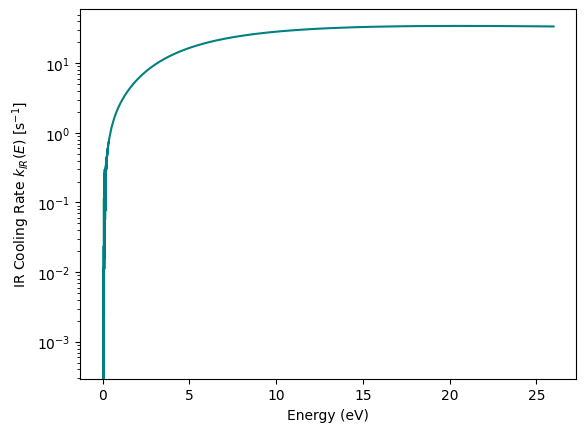

<Figure size 640x480 with 0 Axes>

In [47]:
# THE INFRARED RADIATIVE VIBRATIONAL COOLING RATE 

# WAVENUMBER-INTENSITY & DENSUM DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\densumout_26eV.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\neutral1cyano_transitions.tbl',
    skiprows=11,
    sep='\s+',
    names=["No.", "Wavenumber", "Intensity", "Scale", "Symmetry"])

mode_i_path = r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\1-cyanonaphthalene\vibs\densum_mode_sweeps\mode_{i}\densum.out'
density_mode = {}

for i in range(1, 52):  # Vib modes 1 to 51
    path = mode_i_path.format(i=i)
    if os.path.exists(path):
        df_i = pd.read_csv(path, skiprows=114, sep='\s+', names=["No.", "E-Emin", "Density", "Sum"])
        density_mode[i] = df_i["Density"].values

# LISTS
A_IR_list = []
energy_s_list = []
DOS_list = []
filtered_energies_list = []
wavenumber_list = df2["Wavenumber"].tolist()
intensity_list = df2["Intensity"].tolist()
energies_list = df1["E-Emin"].tolist()
density_of_states_list = df1["Density"].tolist()
N_k_IR_total = np.zeros_like(density_of_states_list) 
DOS_mode_s_dict = {}  # Dictionary to store DOS_mode_s values for each mode

# FUNCTIONS
def einstein_coefficient(wavenumber, intensity):
    A = (1.2512 * 10**(-7)) * (wavenumber ** 2) * intensity
    return A

# CALCULATIONS
for wavenumber, intensity in zip(wavenumber_list, intensity_list):
    A_IR = einstein_coefficient(wavenumber, intensity)
    A_IR_list.append(A_IR)

for mode in range(1, 52):
    wavenumber_s = wavenumber_list[mode - 1]
    rounded_wavenumber = round(wavenumber_s / 10) * 10
    A_IR = A_IR_list[mode - 1]
    # rho_minus_i = density_mode[mode]

    for idx, e in enumerate(energies_list):
        if e <= rounded_wavenumber:
            continue
        E_available = e - rounded_wavenumber
        index = int(E_available / cm_grain)

        DOS_mode_s = density_mode[mode][index]
        k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]
        N_k_IR_total[idx] += k_IR

N_IR_energies_list_eV = [e * cm_to_eV for e in energies_list]

# OPTIONAL PLOTTING
plt.plot(N_IR_energies_list_eV, N_k_IR_total, color='teal')
plt.xlabel("Energy (eV)")
plt.ylabel("IR Cooling Rate $k_{IR}(E)$ [s$^{-1}$]")
plt.yscale('log')
plt.show()
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\N_IR.png')

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_10264\3715461648.py:58: RuntimeWarning: invalid value encountered in scalar divide
  k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]


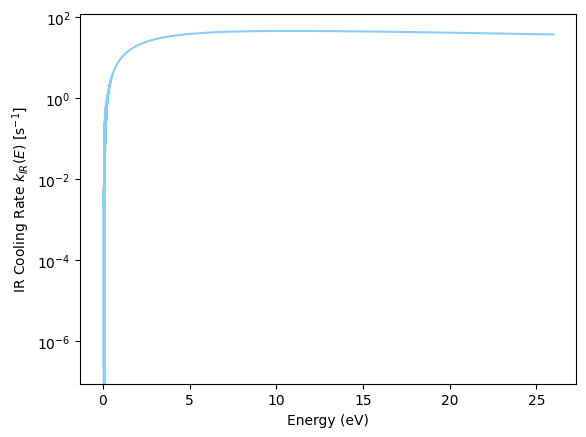

In [48]:
# WAVENUMBER-INTENSITY & DENSUM DATA
df1 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-1-cyanonaphthalene\vibs\densum.out',
    skiprows=115,
    sep='\s+',
    names=["No.", "E-Emin", "Density", "Sum"])

df2 = pd.read_csv(
    r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\cation1cyano_transitions.tbl',
    skiprows=11,
    sep='\s+',
    names=["No.", "Wavenumber", "Intensity", "Scale", "Symmetry"])

mode_i_path = r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\Cynapfolder\Database\Densum_input_1cyano\Models\C-1-cyanonaphthalene\vibs\densum_mode_sweeps\mode_{i}\densum.out'
density_mode = {}

for i in range(1, 52):  # Vib modes 1 to 51
    path = mode_i_path.format(i=i)
    if os.path.exists(path):
        df_i = pd.read_csv(path, skiprows=114, sep='\s+', names=["No.", "E-Emin", "Density", "Sum"])
        density_mode[i] = df_i["Density"].values

# LISTS
A_IR_list = []
energy_s_list = []
DOS_list = []
filtered_energies_list = []
wavenumber_list = df2["Wavenumber"].tolist()
intensity_list = df2["Intensity"].tolist()
energies_list = df1["E-Emin"].tolist()
density_of_states_list = df1["Density"].tolist()
C_k_IR_total = np.zeros_like(density_of_states_list) 
DOS_mode_s_dict = {}  # Dictionary to store DOS_mode_s values for each mode

# FUNCTIONS
def einstein_coefficient(wavenumber, intensity):
    A = (1.2512 * 10**(-7)) * (wavenumber ** 2) * intensity
    return A

# CALCULATIONS
for wavenumber, intensity in zip(wavenumber_list, intensity_list):
    A_IR = einstein_coefficient(wavenumber, intensity)
    A_IR_list.append(A_IR)

for mode in range(1, 52):
    wavenumber_s = wavenumber_list[mode - 1]
    rounded_wavenumber = round(wavenumber_s / 10) * 10
    A_IR = A_IR_list[mode - 1]
    # rho_minus_i = density_mode[mode]

    for idx, e in enumerate(energies_list):
        if e <= rounded_wavenumber:
            continue
        E_available = e - rounded_wavenumber
        index = int(E_available / cm_grain)

        DOS_mode_s = density_mode[mode][index]
        k_IR = (A_IR * DOS_mode_s) / density_of_states_list[idx]
        C_k_IR_total[idx] += k_IR

C_IR_energies_list_eV = [e * cm_to_eV for e in energies_list]

# OPTIONAL PLOTTING
plt.plot(C_IR_energies_list_eV, C_k_IR_total, color='lightskyblue')
plt.xlabel("Energy (eV)")
plt.ylabel("IR Cooling Rate $k_{IR}(E)$ [s$^{-1}$]")
plt.yscale('log')
plt.savefig(r'C:\Users\Mustafa\Documents\GitHub\Project-Cynap\plots\C_IR.png')

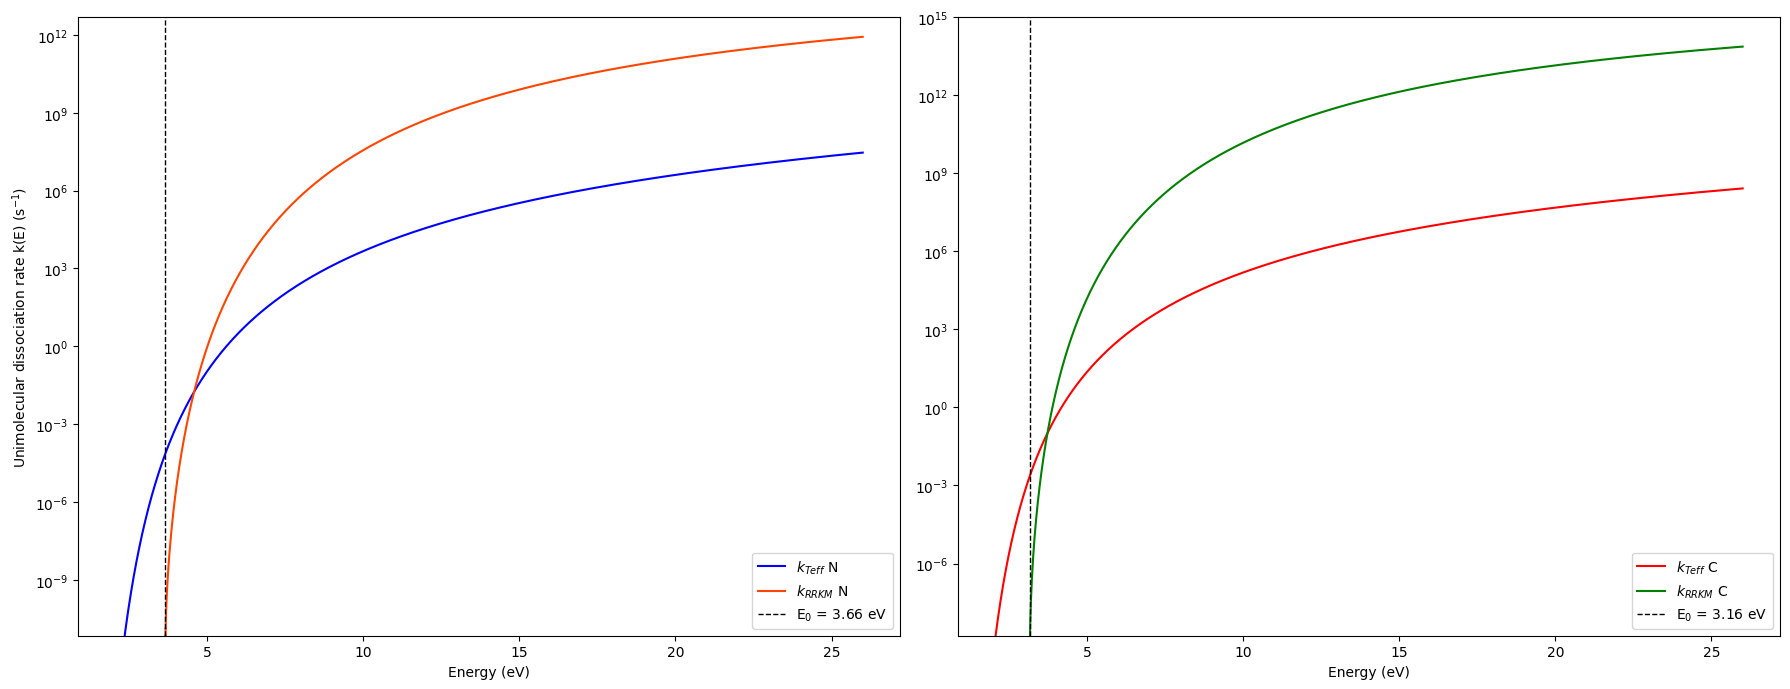

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))

# NEUTRAL 1-CYANONAPHTHALENE DISSOCIATION RATES
axs[0].plot(NC_energies_list, k_diss_N_list, label='$k_{Teff}$ N', color='blue', linestyle='-')
axs[0].plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, label='$k_{RRKM}$ N', color='orangered')
axs[0].axvline(x=3.66, color='black', linestyle='--', linewidth=1, label='E$_0$ = 3.66 eV')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Unimolecular dissociation rate k(E) (s$^{-1}$)')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_ylim(N_k_RRKM_list[0], 5e12)

# CATION 1-CYANONAPHTHALENE DISSOCIATION RATES
axs[1].plot(NC_energies_list, k_diss_C_list, label='$k_{Teff}$ C', color='red', linestyle='-')
axs[1].plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, label='$k_{RRKM}$ C', color='green')
axs[1].axvline(x=3.16, color='black', linestyle='--', linewidth=1, label='E$_0$ = 3.16 eV')
axs[1].set_xlabel('Energy (eV)')
axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_ylim(k_diss_C_list[0], 1e15)
plt.tight_layout()

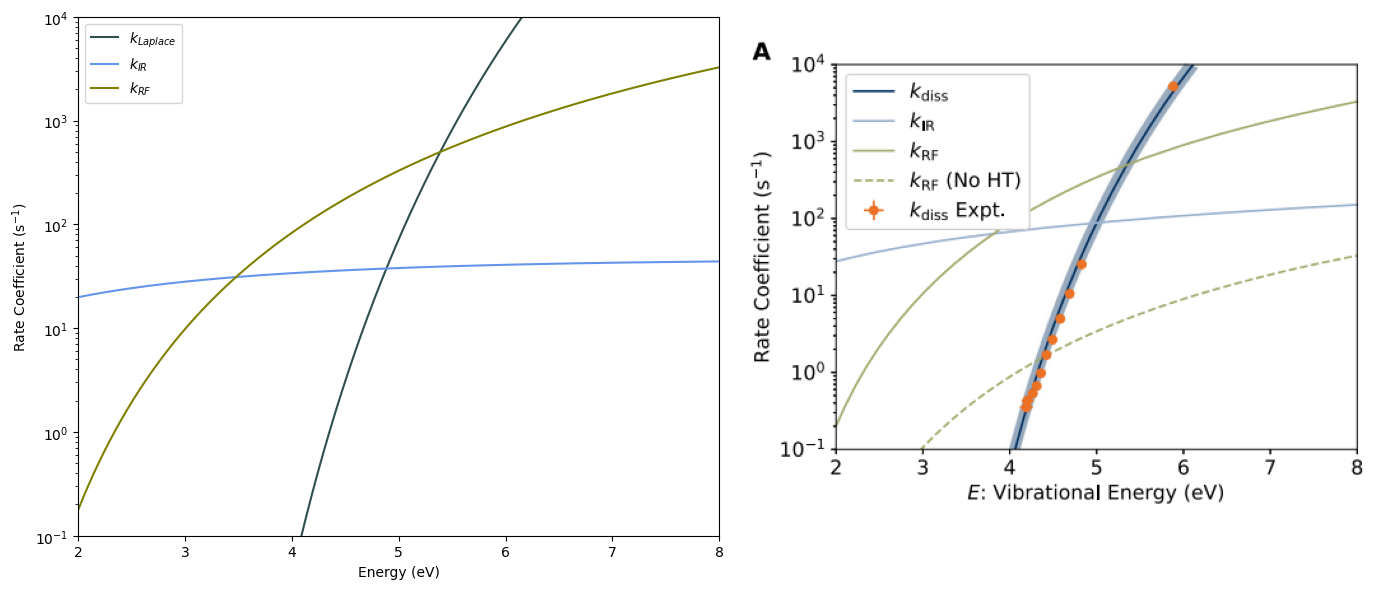

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(LP_filtered_energies_list_eV, C_k_Laplace_list, color='darkslategrey', label='$k_{Laplace}$')
axs[0].plot(C_IR_energies_list_eV, C_k_IR_total, color='cornflowerblue', label='$k_{IR}$')
axs[0].plot(RF_filtered_energies_list_eV, k_RF_list, color='olive', label='$k_{RF}$')
# axs[0].plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='purple', label='k_RRKM')
# axs[0].plot(NC_energies_list, k_diss_C_list, label='k_Teff', color='red')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Rate Coefficient (s$^{-1}$)')
axs[0].set_yscale('log')
axs[0].legend(loc='upper left')
axs[0].set_xlim(2, 8)
axs[0].set_ylim(1e-1, 1e4)

img = mpimg.imread('PaperplotA.png')
axs[1].imshow(img)
axs[1].axis('off')
plt.tight_layout()

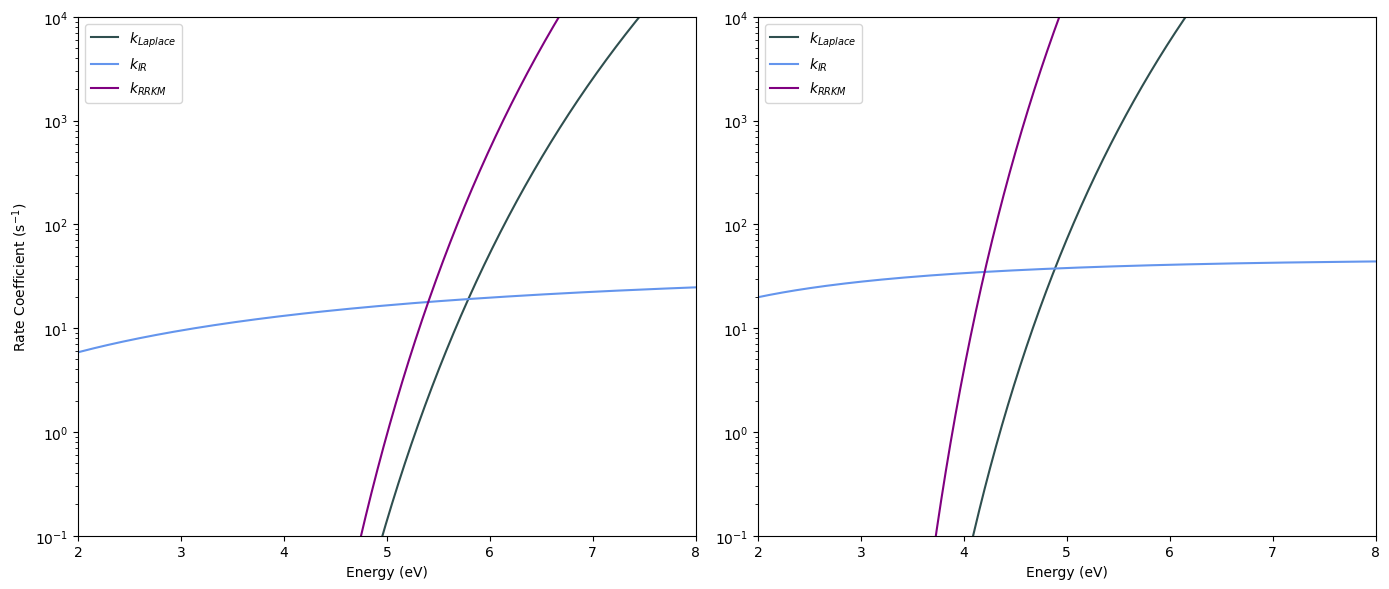

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].plot(N_LP_filtered_energies_list_eV, N_k_Laplace_list, color='darkslategrey', label='$k_{Laplace}$')
axs[0].plot(N_IR_energies_list_eV, N_k_IR_total, color='cornflowerblue', label='$k_{IR}$')
axs[0].plot(N_RRKM_filtered_energies_list_eV, N_k_RRKM_list, color='purple', label='$k_{RRKM}$')
# axs[0].plot(NC_energies_list, k_diss_C_list, label='k_Teff', color='red')
axs[0].set_xlabel('Energy (eV)')
axs[0].set_ylabel('Rate Coefficient (s$^{-1}$)')
axs[0].set_yscale('log')
axs[0].legend(loc='upper left')
axs[0].set_xlim(2, 8)
axs[0].set_ylim(1e-1, 1e4)

axs[1].plot(LP_filtered_energies_list_eV, C_k_Laplace_list, color='darkslategrey', label='$k_{Laplace}$')
axs[1].plot(C_IR_energies_list_eV, C_k_IR_total, color='cornflowerblue', label='$k_{IR}$')
axs[1].plot(C_RRKM_filtered_energies_list_eV, C_k_RRKM_list, color='purple', label='$k_{RRKM}$')
axs[1].set_xlabel('Energy (eV)')
# axs[1].set_ylabel('Rate Coefficient (s$^{-1}$)')
axs[1].set_yscale('log')
axs[1].legend(loc='upper left')
axs[1].set_xlim(2, 8)
axs[1].set_ylim(1e-1, 1e4)


plt.tight_layout()

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_10264\330686981.py:8: RuntimeWarning: invalid value encountered in divide
  C_survival_prob_IR = C_k_IR_total / (C_k_Laplace_interp + C_k_IR_total)
C:\Users\Mustafa\AppData\Local\Temp\ipykernel_10264\330686981.py:9: RuntimeWarning: invalid value encountered in divide
  C_survival_prob_RF = k_RF_interp / (C_k_Laplace_interp + k_RF_interp)


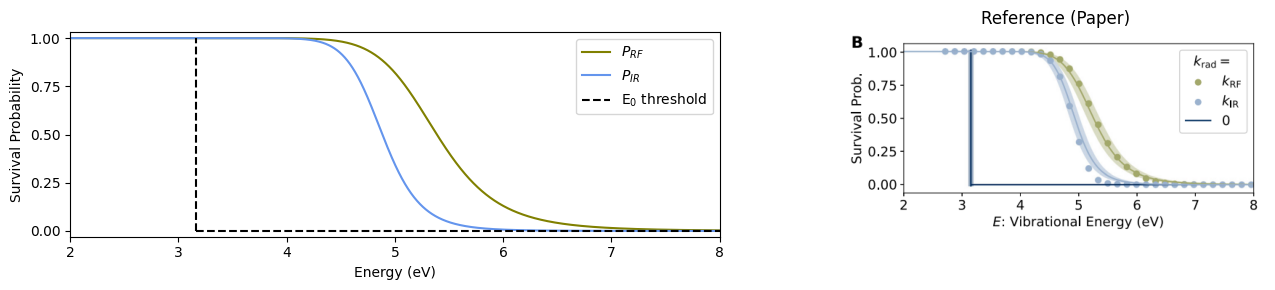

In [92]:
C_threshold_eV = 3.16
interp_laplace = interp1d(LP_filtered_energies_list_eV, C_k_Laplace_list, bounds_error=False, fill_value="extrapolate")
interp_RF = interp1d(RF_filtered_energies_list_eV, k_RF_list, bounds_error=False, fill_value="extrapolate")

C_k_Laplace_interp = interp_laplace(C_IR_energies_list_eV)
k_RF_interp = interp_RF(C_IR_energies_list_eV)

C_survival_prob_IR = C_k_IR_total / (C_k_Laplace_interp + C_k_IR_total)
C_survival_prob_RF = k_RF_interp / (C_k_Laplace_interp + k_RF_interp)

fig, axs = plt.subplots(1, 2, figsize=(14, 3))

axs[0].plot(C_IR_energies_list_eV, C_survival_prob_RF, color='olive', label='$P_{RF}$')
axs[0].plot(C_IR_energies_list_eV, C_survival_prob_IR, color='cornflowerblue', label='$P_{IR}$')
axs[0].plot([C_threshold_eV, C_threshold_eV], [0, 1], color='black', linestyle='--', label='E$_0$ threshold')
axs[0].plot([C_threshold_eV, 8], [0, 0], color='black', linestyle='--')
axs[0].set_xlabel("Energy (eV)")
axs[0].set_ylabel("Survival Probability")
axs[0].set_yticks(np.arange(0, 1.25, 0.25))
axs[0].set_ylim(-0.03, 1.03)
axs[0].set_xlim(2, 8)
axs[0].legend(loc='upper right')

img = mpimg.imread('PaperplotB.png') 
axs[1].imshow(img)
axs[1].axis('off')
axs[1].set_title("Reference (Paper)")

plt.tight_layout()
plt.show()

In [100]:
N_threshold_eV = 3.66
N_interp_laplace = interp1d(N_LP_filtered_energies_list_eV, N_k_Laplace_list, bounds_error=False, fill_value="extrapolate")

N_k_Laplace_interp = N_interp_laplace(N_IR_energies_list_eV)

N_survival_prob_IR = N_k_IR_total / (N_k_Laplace_interp + N_k_IR_total)

axs[0].plot(N_IR_energies_list_eV, N_survival_prob_IR, color='cornflowerblue', label='$P_{IR}$')
axs[0].plot([N_threshold_eV, N_threshold_eV], [0, 1], color='black', linestyle='--', label='E$_0$ threshold')
axs[0].plot([N_threshold_eV, 8], [0, 0], color='black', linestyle='--')
axs[0].set_xlabel("Energy (eV)")
axs[0].set_ylabel("Survival Probability")
axs[0].set_yticks(np.arange(0, 1.25, 0.25))
axs[0].set_ylim(-0.03, 1.03)
axs[0].set_xlim(2, 8)
axs[0].legend(loc='upper right')

plt.tight_layout()
plt.show()

C:\Users\Mustafa\AppData\Local\Temp\ipykernel_10264\1883460080.py:6: RuntimeWarning: invalid value encountered in divide
  N_survival_prob_IR = N_k_IR_total / (N_k_Laplace_interp + N_k_IR_total)


<Figure size 640x480 with 0 Axes>